# 

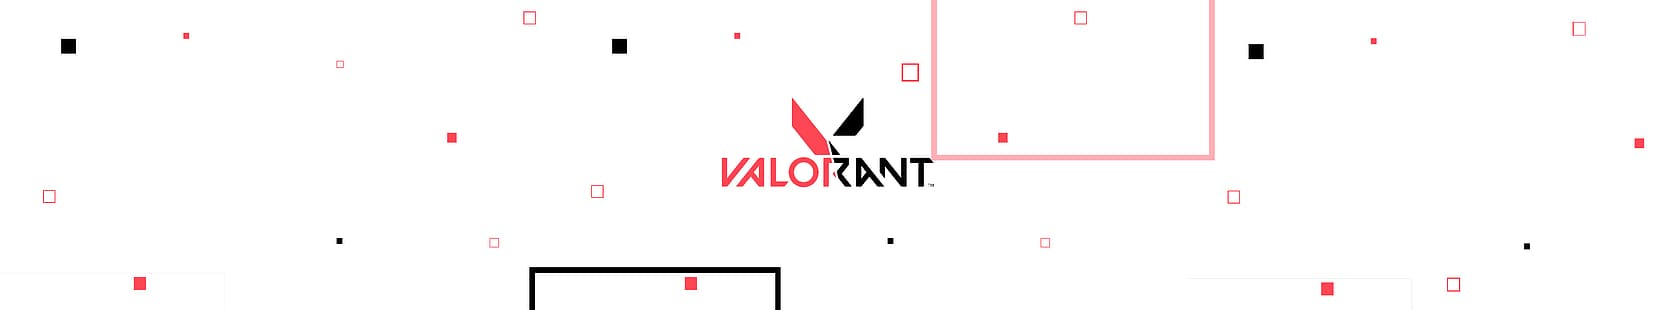

# 

### importing Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# 

### importing Data

In [2]:
df=pd.read_csv("valorant_tweets.csv")

In [3]:
df.head()

,tweet,date,Agent,Role
0,and now i want brimstone in my garden\ni want ...,2021-09-29 22:30:50,Brimstone,Controller
1,why half of the brimstone players are literall...,2021-09-29 22:14:44,Brimstone,Controller
2,@DavidLevy101 @Meloniemaher1 That fucker gets ...,2021-09-29 22:07:50,Brimstone,Controller
3,They also did these cute lil' ghosts! \n\nRobo...,2021-09-29 22:01:21,Brimstone,Controller
4,@AuthorDelaneyW @mis_cue @C_Stroop That is not...,2021-09-29 21:57:18,Brimstone,Controller


# 

### Defining StopWords Remover 

In [4]:
# Removing Stopwords
import nltk
# nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize

stop_words = stopwords.words('english')
 
def remove_stopwords(rev):

    review_tokenized = word_tokenize(rev)
    rev_new = " ".join([i for i in review_tokenized  if i not in stop_words])
    return rev_new

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ajesh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 

### Defining Lemmatization

In [5]:
# Begin Lemmatization 
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

# function to convert nltk tag to wordnet tag
lemmatizer = WordNetLemmatizer()

# Finds the part of speech tag
# Convert the detailed POS tag into a shallow information
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

# lemmatize sentence using pos tag
def lemmatize_sentence(sentence):
  # word tokenize -> pos tag (detailed) -> wordnet tag (shallow pos) -> lemmatizer -> root word
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ajesh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ajesh\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ajesh\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# 

# 

### Creating class for Data cleaning & Bagging 

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin


#Data_cleaning

class Data_cleaning (BaseEstimator, TransformerMixin) :
    def fit (self, X, y=None) :
        return self

    def transform (self, X) :
        X['tweet'] = X['tweet'].str.replace("[^a-zA-Z0-9]", " ")
        X['tweet'] = X['tweet'].apply(lambda row: ' '.join([word for word in row.split() if len(word)>2]))
        X['tweet'] = [review.lower() for review in X['tweet']]
        X['tweet'] = [remove_stopwords(r) for r in X['tweet']]
        X['tweet'] = X['tweet'].apply(lambda x: lemmatize_sentence(x))
        X = pd.get_dummies(X, columns = ['Role'])
        X = X.drop(["date"], axis='columns')
        X['Agent']=X.Agent.map({
            'Astra': 0,
            'Breach': 1,
            'Brimstone':2,
            'Cypher':3,
            'Jett':4,
            'Kayo':5,
            'Killjoy':6,
            'Omen':7,
            'Phoenix':8,
            'Raze':9,
            'Reyna':10,
            'Sage':11,
            'Skye':12,
            'Sova':13,
            'Viper':14,
            'Yoru':15
        })
        return X

### 

In [7]:
    
#Bagging
class Bagging (BaseEstimator, TransformerMixin) :
    def fit (self, X, y=None) :
        return self

    def transform (self, X) :
        tfidf = TfidfVectorizer(max_features=2500)

        data= tfidf.fit_transform(X.tweet)

        feature_names = tfidf.get_feature_names()
        data=pd.DataFrame(data.toarray(), columns = feature_names)
        X= pd.concat([X,data], axis=1)
        X = X.drop(["tweet"], axis='columns')
        return X

# 

### Creating pipeline for preprocessing

In [8]:
from sklearn. pipeline import Pipeline
preprocessing = Pipeline([
    ("Data_cleaning", Data_cleaning()),
    ("Bagging ",Bagging())
])

In [9]:
df=preprocessing .fit_transform(df)

C:\Users\ajesh\AppData\Local\Temp\ipykernel_2236\346308769.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  X['tweet'] = X['tweet'].str.replace("[^a-zA-Z0-9]", " ")
C:\Users\ajesh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [10]:
df.head()

,Agent,Role_Controller,Role_Duelist,Role_Initiator,Role_Sentinel,000,0oty,100,1000,10velbs,...,youtube,yung,zalpepvw0p,zardes,zeneca,zenica,zero,zeroday,zerorice1012,zozie
0,2,1,0,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1,0,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,1,0,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2,1,0,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2,1,0,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 

### Splitting 

In [11]:
X = df.drop('Agent', axis=1)
y = df['Agent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20,shuffle=True)

# 

### Creating pipeline For Modeling

In [12]:
pipeline_lr=Pipeline([('scalar1',StandardScaler()),
                     ('lr_classifier',LogisticRegression(random_state=0))])


In [13]:
pipeline_dt=Pipeline([('scalar2',StandardScaler()),
                     ('dt_classifier',DecisionTreeClassifier())])

In [14]:
pipeline_randomforest=Pipeline([('scalar3',StandardScaler()),
                     ('rf_classifier',RandomForestClassifier())])

In [15]:
pipelines = [pipeline_lr, pipeline_dt, pipeline_randomforest]

In [16]:
best_accuracy=0.0
best_classifier=0
best_pipeline=""

### 

### Fitting a model

In [17]:
# Dictionary of pipelines and classifier types for ease of reference
pipe_dict = {0: 'Logistic Regression', 1: 'Decision Tree', 2: 'RandomForest'}

# Fit the pipelines
for pipe in pipelines:
    pipe.fit(X_train, y_train)


C:\Users\ajesh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### 

### Evaluation  

In [18]:
for i,model in enumerate(pipelines):
    print("{} Test Accuracy: {}".format(pipe_dict[i],model.score(X_test,y_test)))


Logistic Regression Test Accuracy: 0.8635923895517575
Decision Tree Test Accuracy: 0.9032570138664947
RandomForest Test Accuracy: 0.9113189293776202


# 

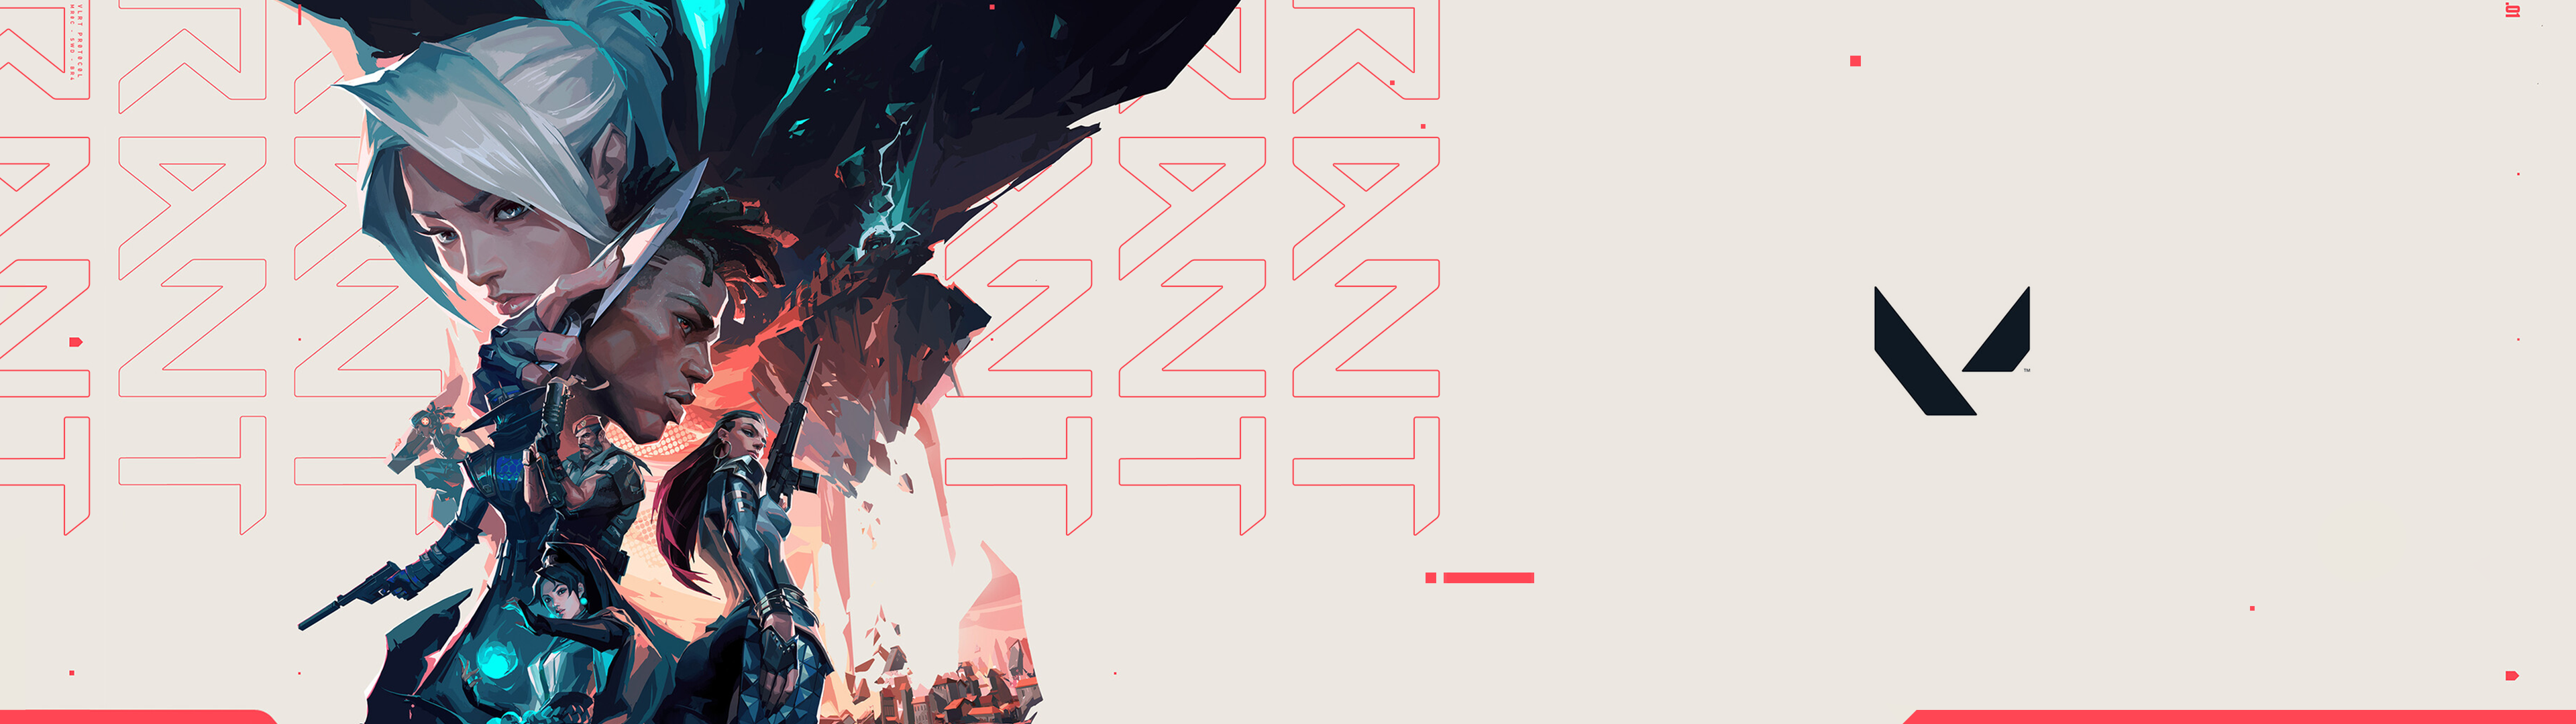